# Type Investigations
-------

In this notebook I am going to engineer the several features I'll be using to summarize the strengths and weaknesses of current pokemon and then create those same calculations for type-pairings that do not exist.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
poke_pivot = pd.read_csv('Data/poke_pivot.csv',       index_col = 0) 
advantages = pd.read_csv('Data/advantages.csv',       index_col = 0)
pokemon    = pd.read_csv('Data/pokedex_formal_2.csv', index_col = 0)

**Offensive Advantages**
   - Given a Pokemon with a combination of two types, which other types can this Pokemon potentially have an offensive advantage over given its move pool. (`Super Effective` attacks) 
   
**Offensive Disadvantages**
   - Given a Pokemon with a combination of two types, which other types can this Pokemon potentially have an offensive disadvantage over given its move pool. (`Not Very Effective` attack or `Doesn't Affect`). 
   
   
**Offensive Power**   
- Given that it is this Pokemon's turn to attack, this is the sum of this Pokemons _best_ offensive attack multipliers per each opposing single type.  
   
**Defensive Power**  
   -  Given how damage is calculate across a defending Pokemon with two different types. What is the sum of damage distributed multipliers. There are 19 individual types, so if a Pokemon's type combination has no Defensive advantages or disadvantages and all attacks against do base damage, their Defensive Power will be 19 `(1.0 * 19)`. For this stat, lower is better.
   
**Defensive Advantages**
   - Which types of attacks are `not very effective` against this Pokemon.
   
**Defensive Disadvantages**
   - Which types of attacks are `super effective` against this Pokemon.
   
**Immunities**
   - Which types of attacks will have no affect on this Pokemon. 

In [3]:
# Take two types and return their Offensive and defensive abilities.
# This one is for printing things out only
def consequences(type1, type2, advantages = advantages):
  
    # Offensive Advantages
    advantages_o = []
    for types in [type1, type2]:
        try:
            [advantages_o.append(item) for item in list(advantages[advantages.T[types] == 2.0].index.values) if item not in advantages_o]
        except:
            pass
    print('Offensive Advantages    : ',advantages_o)
    
    # Offensive Disadvantages
    disadvantages_o = []
    for def_type in advantages.columns:
        sub_set = list(advantages.T[[type1, type2]].loc[def_type])
        if (sub_set[0] < 1 and  sub_set[1] < 1):
            max_weak = max(sub_set)
            disadvantages_o.append('%s : %s' %(def_type,max_weak ))
    if len( disadvantages_o) > 0:
        print('Offensive Disadvantages : ',disadvantages_o)
    else:
        print('Offensive Disadvantages :  None')
        
    # Offensive Power
    offensive_power = sum([a if a > b else b for a,b in advantages.loc[[type1, type2]].T.values])
    print('Offensive Power         : ', offensive_power)
    # Defensive Advantages, Disadvantages & Immunities
    advantages_d = []
    disadvantages_d = []
    immunity = []
    defensive_power = 0

    # If statement for similar types
    if type1 == type2:
        defensive_power = advantages[type1].sum()
        for name, value in zip(advantages[['Fire']].index, advantages[['Fire']].values) :
            if value[0] == 0:
                immunity.append(name)
    
            if 0 < value[0] < 1 :
                advantages_d.append('%s : %s' %(name, value[0]))
    
            if value[0] > 1:
                disadvantages_d.append('%s : %s' %(name, value[0]))
        
    else:
        for types in advantages.columns:
            row = advantages[[type1,type2]].loc[types]
            defensive_power += row[0]*row[1]
            if 0 < row[0]*row[1] < 1:
                advantages_d.append('%s : %s' %(row.name, row[0]*row[1]))

            if  row[0]*row[1] > 1:
                disadvantages_d.append('%s : %s' %(row.name, row[0]*row[1]))

            if row[0]*row[1] == 0:
                immunity.append(row.name)
    print('Defensive Power         : ',defensive_power )
    print('Defensive Advantages    : ',advantages_d)
    print('Defensive Disadvantages : ',disadvantages_d)
    print('Immunities              : ',immunity)
    
    
    # dictionary for storing info 
    capabilities = {'off_adv'       : advantages_o    , 'count_off_adv' : len(advantages_o),
                    'off_disadv'    : disadvantages_o , 'count_off_dis' : len(disadvantages_o),
                    'off_pwr'       : offensive_power ,
                    'def_adv'       : advantages_d    , 'count_def_adv' : len(advantages_d),
                    'def_disadv'    : disadvantages_d , 'count_def_dis' : len(disadvantages_d),
                    'def_pwr'       : defensive_power ,
                    'immunities'    : immunity        , 'imm_count'     : len(immunity)}
    return capabilities
consequences('Fire','Flying')

Offensive Advantages    :  ['Bug', 'Grass', 'Ice', 'Steel', 'Fighting']
Offensive Disadvantages :  ['Rock : 0.5']
Offensive Power         :  22.5
Defensive Power         :  18.5
Defensive Advantages    :  ['Bug : 0.25', 'Fairy : 0.5', 'Fighting : 0.5', 'Fire : 0.5', 'Grass : 0.25', 'Steel : 0.5']
Defensive Disadvantages :  ['Electric : 2.0', 'Rock : 4.0', 'Water : 2.0']
Immunities              :  ['Ground']


{'off_adv': ['Bug', 'Grass', 'Ice', 'Steel', 'Fighting'],
 'count_off_adv': 5,
 'off_disadv': ['Rock : 0.5'],
 'count_off_dis': 1,
 'off_pwr': 22.5,
 'def_adv': ['Bug : 0.25',
  'Fairy : 0.5',
  'Fighting : 0.5',
  'Fire : 0.5',
  'Grass : 0.25',
  'Steel : 0.5'],
 'count_def_adv': 6,
 'def_disadv': ['Electric : 2.0', 'Rock : 4.0', 'Water : 2.0'],
 'count_def_dis': 3,
 'def_pwr': 18.5,
 'immunities': ['Ground'],
 'imm_count': 1}

**The below Version is for the most part the same function, but returns information as a dictionary which will be useful for appending columns to the existing pokemon dataframe.**

In [4]:
def capabilities(type1, type2, advantages = advantages):
  
    # Offensive Advantages
    advantages_o = []
    for types in [type1, type2]:
        try:
            [advantages_o.append(item) for item in list(advantages[advantages.T[types] == 2.0].index.values) if item not in advantages_o]
        except:
            pass
    
    # Offensive Disadvantages
    disadvantages_o = []
    for def_type in advantages.columns:
        sub_set = list(advantages.T[[type1, type2]].loc[def_type])
        if (sub_set[0] < 1 and  sub_set[1] < 1):
            max_weak = max(sub_set)
            disadvantages_o.append('%s : %s' %(def_type,max_weak ))
        
    # Offensive Power
    offensive_power = sum([a if a > b else b for a,b in advantages.loc[[type1, type2]].T.values])
    
    # Defensive Advantages, Disadvantages & Immunities
    advantages_d = []
    disadvantages_d = []
    immunity = []
    defensive_power = 0

    # If statement for similar types
    if type1 == type2:
        defensive_power = advantages[type1].sum()
        for name, value in zip(advantages[['Fire']].index, advantages[['Fire']].values) :
            if value[0] == 0:
                immunity.append(name)
    
            if 0 < value[0] < 1 :
                advantages_d.append('%s : %s' %(name, value[0]))
    
            if value[0] > 1:
                disadvantages_d.append('%s : %s' %(name, value[0]))
        
    else:
        for types in advantages.columns:
            row = advantages[[type1,type2]].loc[types]
            defensive_power += row[0]*row[1]
            if 0 < row[0]*row[1] < 1:
                advantages_d.append('%s : %s' %(row.name, row[0]*row[1]))

            if  row[0]*row[1] > 1:
                disadvantages_d.append('%s : %s' %(row.name, row[0]*row[1]))

            if row[0]*row[1] == 0:
                immunity.append(row.name)
    
    # dictionary for storing info 
    capabilitys = {'off_adv'       : advantages_o    , 'count_off_adv' : len(advantages_o),
                    'off_disadv'    : disadvantages_o , 'count_off_dis' : len(disadvantages_o),
                    'off_pwr'       : offensive_power ,
                    'def_adv'       : advantages_d    , 'count_def_adv' : len(advantages_d),
                    'def_disadv'    : disadvantages_d , 'count_def_dis' : len(disadvantages_d),
                    'def_pwr'       : defensive_power ,
                    'immunities'    : immunity        , 'count_imm'     : len(immunity)}
    
    return capabilitys


capabilities('Fire','Flying')

{'off_adv': ['Bug', 'Grass', 'Ice', 'Steel', 'Fighting'],
 'count_off_adv': 5,
 'off_disadv': ['Rock : 0.5'],
 'count_off_dis': 1,
 'off_pwr': 22.5,
 'def_adv': ['Bug : 0.25',
  'Fairy : 0.5',
  'Fighting : 0.5',
  'Fire : 0.5',
  'Grass : 0.25',
  'Steel : 0.5'],
 'count_def_adv': 6,
 'def_disadv': ['Electric : 2.0', 'Rock : 4.0', 'Water : 2.0'],
 'count_def_dis': 3,
 'def_pwr': 18.5,
 'immunities': ['Ground'],
 'count_imm': 1}

In [5]:
capabilities('Fire','Fire')

{'off_adv': ['Bug', 'Grass', 'Ice', 'Steel'],
 'count_off_adv': 4,
 'off_disadv': ['Dragon : 0.5', 'Fire : 0.5', 'Rock : 0.5', 'Water : 0.5'],
 'count_off_dis': 4,
 'off_pwr': 20.0,
 'def_adv': ['Bug : 0.5',
  'Fairy : 0.5',
  'Fire : 0.5',
  'Grass : 0.5',
  'Ice : 0.5',
  'Steel : 0.5'],
 'count_def_adv': 6,
 'def_disadv': ['Ground : 2.0', 'Rock : 2.0', 'Water : 2.0'],
 'count_def_dis': 3,
 'def_pwr': 18.0,
 'immunities': [],
 'count_imm': 0}

In [6]:
import pickle
pickle.dump(capabilities, open( "./Python-Files/cap_fun.p", "wb" ))

In [7]:
# Since i was returning the previous as a dict, i needed to convert to a list for my df creation.
def cap_to_list(capability):
    O_list = [capability['count_def_adv'], capability['count_def_dis'], capability['def_adv'],
              capability['count_off_adv'], capability['count_off_dis'], capability['off_adv'],
              capability['count_imm'    ], capability['def_disadv'   ], capability['def_pwr'], 
              capability['immunities'   ], capability['off_disadv'   ], capability['off_pwr']]
    return O_list


## What is the Norm?

**What is the average Offensive and Defensive Power's of existing Pokemon as well as their distributions?**

**On average how many Offensive and Defensive _advantages_ do existing Pokemon have?**

**On average how many Offensive and Defensive _disadvantages_ do existing Pokemon have?**

In [8]:
pokemon.columns

Index(['Name', 'Type', 'Total', 'HP', 'Attack', 'Defense', 'SpecialAttack',
       'SpecialDefense', 'Speed', 'Type_P', 'Type_S', 'Mega', 'legendary',
       'GENERATION', 'Stage', 'EVS', 'FAMILY_ID', 'IS STUPID'],
      dtype='object')

In [9]:
new_cols = ['count_def_adv', 'count_def_dis', 'def_adv', 
            'count_off_adv', 'count_off_dis', 'off_adv',
            'count_imm'    , 'def_disadv'   , 'def_pwr',
            'immunities'   , 'off_disadv'   , 'off_pwr']

In [10]:
# Calculating the Stat Capabilities for all the Pokemon
cap_df = pd.DataFrame(columns=new_cols)
for index in range(len(pokemon)):
    row = pokemon.iloc[index]
    #print(row[['Type_P','Type_S']],)
    cap_df.loc[len(cap_df)] = cap_to_list(capabilities(*row[['Type_P','Type_S']]))

In [11]:
cap_df.shape

(782, 12)

In [12]:
cap_df.head(2)

,count_def_adv,count_def_dis,def_adv,count_off_adv,count_off_dis,off_adv,count_imm,def_disadv,def_pwr,immunities,off_disadv,off_pwr
0,5,4,"[Electric : 0.5, Fairy : 0.5, Fighting : 0.5, ...",5,2,"[Ground, Rock, Water, Fairy, Grass]",0,"[Fire : 2.0, Flying : 2.0, Ice : 2.0, Psychic ...",19.25,[],"[Poison : 0.5, Steel : 0.5]",22.0
1,5,4,"[Electric : 0.5, Fairy : 0.5, Fighting : 0.5, ...",5,2,"[Ground, Rock, Water, Fairy, Grass]",0,"[Fire : 2.0, Flying : 2.0, Ice : 2.0, Psychic ...",19.25,[],"[Poison : 0.5, Steel : 0.5]",22.0


In [13]:
# Index needed to be reset as it was set to the pokedex id
pokemon.reset_index(inplace = True)

In [14]:
# Concatting Pokemon DF with the Capabilities DF
pokemon2 = pd.concat([pokemon,cap_df], axis =1 )

In [15]:
# List of quantitative values I would like to analyze
histo_listo = ['count_def_adv','count_def_dis','def_pwr',
               'count_off_adv','count_off_dis', 'off_pwr', 'count_imm',]

# turns out some of them got interpreted as Objects instead of float.
pokemon2[histo_listo].dtypes

count_def_adv     object
count_def_dis     object
def_pwr          float64
count_off_adv     object
count_off_dis     object
off_pwr          float64
count_imm         object
dtype: object

In [16]:
# Casting columns as floats
pokemon2['count_def_adv'] = pokemon2['count_def_adv'].astype(float)
pokemon2['count_def_dis'] = pokemon2['count_def_dis'].astype(float)
pokemon2['count_off_adv'] = pokemon2['count_off_adv'].astype(float)
pokemon2['count_off_dis'] = pokemon2['count_off_dis'].astype(float)
pokemon2['count_imm']     = pokemon2['count_imm'].astype(float)

**Need to Remove Legendaries and Mega Evolutions**

In [17]:
print(pokemon2.shape)
print(pokemon2['legendary'].value_counts())
print(pokemon2['Mega'].value_counts())

# Givent that there are pokemon like Mega Mewtwo and Mega Requaza that are both Mega and Legendary
# there is not a one-to-one tally of all pokemon we'll remove.

pokemon3 = pokemon2[(pokemon2['legendary'] ==0) & (pokemon2['Mega'] == 0)]
pokemon3.shape

(782, 31)
0    709
1     73
Name: legendary, dtype: int64
0    734
1     48
Name: Mega, dtype: int64


(667, 31)

_If these aren't normally distributed, imma be annoyed._

---

### Count of Defensive Advantages

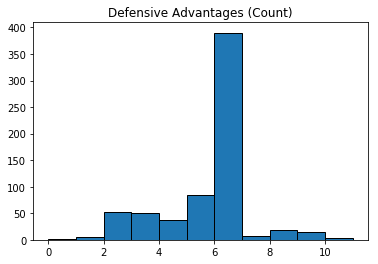

Median :  6.0
Mode   :  6.0


,count,mean,std,min,25%,50%,75%,max
count_def_adv,667.0,5.308846,1.613744,0.0,5.0,6.0,6.0,11.0


In [38]:
plt.hist(pokemon3['count_def_adv'], 
         ec = 'black', # black lines separating bins
         bins = int(pokemon3['count_def_adv'].max())) # 1 bin for each value

plt.title('Defensive Advantages (Count)')
plt.show()

print("Median : ",  pokemon3['count_def_adv'].median())
print("Mode   : ", pokemon3['count_def_adv'].mode()[0])
pokemon3[['count_def_adv']].describe().T

6 seems like a very common number of Def Advantages to have, therefore I'd accept new type combos with 6 defensive advantages without any issue, as well as 5 and 4 to move the distribution towards a more consistent left slope.  I would also accept those with 7 advantages, but have to consider other stats to make sure they have a complementary disadvantage (possibly offensively).

**Take Aways**
- `6`'s are acceptable
- `7`'s        would need minor complementary disadvantage.
- `8, 9 or 10` would need major complementary disadvantage.(Will probably avoid)
- `4` or `5`'s would need minor complementary advantage.
- `2` or `3`s  would need major complementary advantage.
- `1` or lower would not be advised.  

---

### Count of Defensive Disadvantages

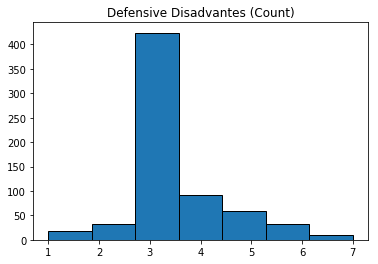

Median :  3.0
Mode   :  3.0


,count,mean,std,min,25%,50%,75%,max
count_def_dis,667.0,3.416792,1.071142,1.0,3.0,3.0,4.0,7.0


In [37]:
plt.hist(pokemon3['count_def_dis'],
         ec = 'black', 
         bins = int(pokemon3['count_def_dis'].max()))

plt.title('Defensive Disadvantes (Count)')
plt.show()

print("Median : ",  pokemon3['count_def_dis'].median())
print("Mode   : ", pokemon3['count_def_dis'].mode()[0])
pokemon3[['count_def_dis']].describe().T


Defensive Disadvantages tend to hover around 3, so I would accept most new pairings with 3 defensive disadvantages, but be skeptical about 2 but not opposed to it if the conditions of other stat summaries indicate a greater than normal weakness elsewhere.


**Take Aways**
- `3`'s are acceptable
- `1` or `2`'s need major complementary disadvantage(s).
- `4, 5, 6` & `7`'s would need minor complementary advantage(s).

---

### Count of Offensive Advantages

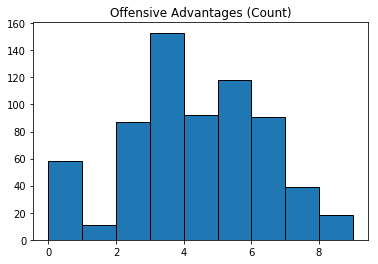

Median :  4.0
Mode   :  3.0


,count,mean,std,min,25%,50%,75%,max
count_off_adv,667.0,3.850075,1.998876,0.0,3.0,4.0,5.0,9.0


In [39]:
plt.hist(pokemon3['count_off_adv'], 
         ec = 'black', 
         bins = int(pokemon3['count_off_adv'].max()))

plt.title('Offensive Advantages (Count)')
plt.show()

print("Median : ",  pokemon3['count_off_adv'].median())
print("Mode   : ", pokemon3['count_off_adv'].mode()[0])
pokemon3[['count_off_adv']].describe().T

Most normal like distribution I have seen so far.  Noticeable gaps I would like to address are the pokémon with only 1 Offensive Advantage.  3 tends to be the most common, but in order to keep normal dist consistency I would also be ok accepting pokémon with 4 offensive advantages.

**Take Aways**
- `2`, `3` & `4`s are acceptable.
- `1`s would need some minor complementary advantage.
- `5` & `6`s would need some minor complementary disadvantage.
- `7` and `8`s would need a major complementary disadvantage
- `0`, Should not appear as this is not possible with combinations that are not pure normal types.

_There are a lot of `0`s because Normal type pokémon and normal type moves. (Although most normal types can learn a variety of move types._

---

### Count of Offensive Disadvantages

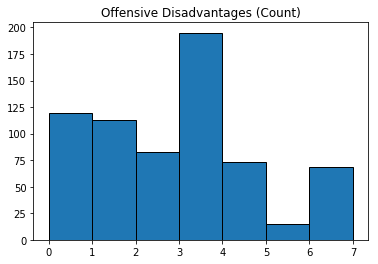

Median :  3.0
Mode   :  3.0


,count,mean,std,min,25%,50%,75%,max
count_off_dis,667.0,2.53973,1.961222,0.0,1.0,3.0,3.0,7.0


In [40]:
plt.hist(pokemon3['count_off_dis'],
         ec = 'black', 
         bins = int(pokemon3['count_off_dis'].max()) )

plt.title('Offensive Disadvantages (Count)')
plt.show()

print("Median : ",  pokemon3['count_off_dis'].median())
print("Mode   : ", pokemon3['count_off_dis'].mode()[0])
pokemon3[['count_off_dis']].describe().T

This is a strange distribution... I Think its interesting that there are already so many pokemon who have 0 or 1 offensive disadvantages.  Given that it is uncommon to be at an offensive disadvantage, having a 1 or 2 there doesn't bother me. 

**Take Aways**
- 1,2,3 & 4s would be acceptable.
- 0  would require minor complementary disadvantages
- 5 & 6 s I would try to avoid as they would require major complementary advantages.

_Once again that large block at the end is most likely a result of the normal pokémons. _

---

### Defensive Power

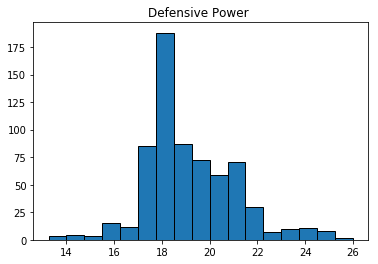

Defensive Power is the sum of a pokemon's defense multipliers for all attacking types : Lower = Better
Median :  18.75
Mode   :  18.0


,count,mean,std,min,25%,50%,75%,max
def_pwr,667.0,19.060345,1.911326,13.25,18.0,18.75,20.0,26.0


In [41]:
plt.hist(pokemon3['def_pwr'],
         ec = 'black', 
         bins = 17 )
plt.title("Defensive Power ")
plt.show()
print("Defensive Power is the sum of a pokemon's defense multipliers for all attacking types : Lower = Better")

print("Median : ",  pokemon3['def_pwr'].median())
print("Mode   : ", pokemon3['def_pwr'].mode()[0])
pokemon3[['def_pwr']].describe().T

Mean and Median are pretty close and seems like a lot exist in that 25% - 50% quartile. I'll utilize the Standard Deviation for this value.

Given the skew right, the standard deviation range used on the right will be more lenient.

**Take Aways**
- Values within 1 standard Deviation(~2) from the rounded mean of 19 are acceptable.
    * `17 - 21`
- Values between 1 and 2 STDs below the mean would require minor complementary disadvantage(s)
    * `15 - 17`
- Values greater than 2 STDs below the mean would require major complementary disadvantage(s)
    * `< 15`
- Values between 1 and 3 STDs above the mean would require minor complementary advantage(s)
    * `19 - 23`
- Values greater than 3 STDs above the mean would require major complementary advantage(s)
    * `> 23`
    
---

### Offensive Power

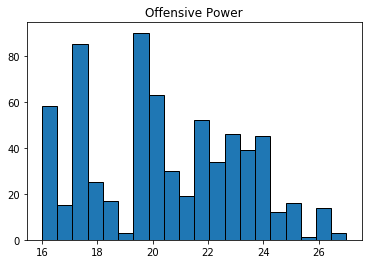

Offensive Power is the sum of a pokemon's Attack multipliers for all defending types : Higher = Better
Median :  20.0
Mode   :  19.5


,count,mean,std,min,25%,50%,75%,max
off_pwr,667.0,20.449025,2.732648,16.0,18.0,20.0,23.0,27.0


In [42]:
plt.hist(pokemon3['off_pwr'], 
         ec = 'black', 
         bins = 20)
plt.title("Offensive Power")
plt.show()
print("Offensive Power is the sum of a pokemon's Attack multipliers for all defending types : Higher = Better")

print("Median : ",  pokemon3['off_pwr'].median())
print("Mode   : ", pokemon3['off_pwr'].mode()[0])
pokemon3[['off_pwr']].describe().T

This distribution seems wildly erratic.  Ideally it would be nice to transform this to some kind of normal distribution.  Those damn normal types are visually ruining the eyes interpretation of the graph.  Having a Normal type attack will total to that 16 offensive power there are so many of.  
What else I see is the mean and median as well as mode converging around 20, which is that spike in the middle our eyes get drawn to.  By filling in both sides and accepting more pokemon within 1 STD (~2.5) of the mean (~20.5) we can move this distribution to a more normal one.


**Take Aways**
- Values within 1 standard Deviation(~2.5) from the rounded mean of 20.5 are acceptable.
    * `18 - 23`
- Values between 1 and 2 STDs below the mean would require minor complementary advantage(s)
    * `15.5 - 18`
- Values between 1 and 2 STDs above the mean would require minor complementary disadvantage(s)
    * `23 - 25.5`
- Values greater than 2 STDs above the mean would require major complementary disadvantage(s)
    * `> 25.5`

---

### Count of Immunities

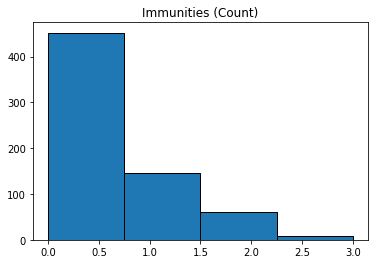

In [28]:
plt.hist(pokemon3['count_imm'], ec = 'black', bins = 4, )
plt.title('Immunities (Count)')
plt.show()

3 seems to be the extreme, I would like to see who those cases are.

**Take Aways**
- 0 Immunities are acceptable
- 1 Immunity would need a minor complementary disadvantage. 
- 2+ Immunities would need major complementary disadvantage(s)

In [29]:
focus_stats = pokemon3[histo_listo].describe()

focus_stats.to_csv("./Data/focus_stats.csv",)

In [30]:
pokemon3.to_csv('./Data/pokemon3')